# High Level Pipline for GCN and GNODE for Brain State Identification

## Pipeline Overview

### 1.1 Adjacency Matrix Generation ---> **2.1 Unsupervised GCN** ---> 3.1 Supervised MLP

### 1.1 Adjacency Matrix Generation ---> **2.2 Unsupervised GNODE** ---> 3.1 Supervised MLP

[Introduction and overview should be written here]

#### High Level Classes imported:

DataManager.py DataManagerUtil.py : [insert description here]

GCN.py GCNutil.py : [insert description here]

GDE.py GDEutil.py GDEsolvers.py : [insert description here]

MLP.py : [insert description here]

In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

#### Dataset:

[A short description here]

name: X_test
shape: (640, 35, 2649)
-----------------------
name: X_train
shape: (640, 35, 2564)
-----------------------
name: clip_sizes_test
shape: (2, 102)
-----------------------
name: clip_sizes_train
shape: (2, 101)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2649)
-----------------------
name: sel_win_nums_train
shape: (1, 2564)
-----------------------
name: soz_ch_ids
shape: (7, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2649)
-----------------------
name: y_train
shape: (1, 2564)
-----------------------
print sample EGG signal from one node:


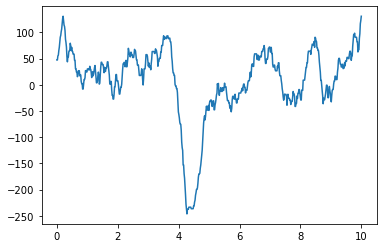

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_273.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [32]:
#OPTIONAL: Shuffle the dataset
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, print_summary = True)

KeyboardInterrupt: 

In [101]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

In [5]:
#save the shuffled indices
np.save("datasets/indices_253.npy",indices)

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 1.1 Adjacency Matrix Generation

[short description here]

##### 1.1.1 Create the datamanager object that computes the covariance matrix for you.

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
#dm.apply_dvariance_filter(30)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)


In [5]:
#from DataManager import extend_identity as extend_identity
#print(extend_identity(2500,16), extend_identity(2500,16).shape)
print(dm)
#dm.resize_clip(64)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)


##### 1.1.2 Visualize the mean covariance matrix across all training samples

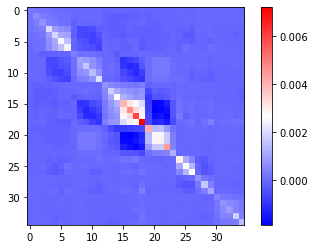

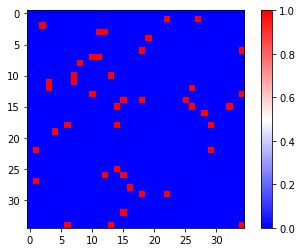

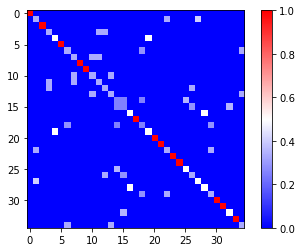

In [23]:
show_heat_map(dm.P_avg_train)

##### 1.1.3 Create DAD from dm by setting the threshold n. repeating this untill a desireble "n" value is found.

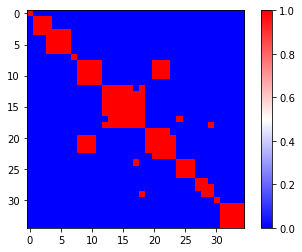

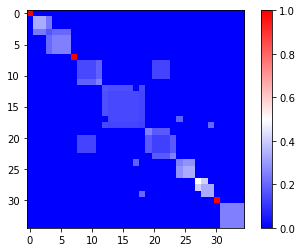

In [24]:
n = 2.5*10**-4
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Convolutional Neural Network (GCN)

[short description here]

##### 2.1.1 Declare Parameters for GCN

In [25]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 512,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(GCNparameters)
GCNcheckpoint = {'parameters': GCNparameters}

{'body': 640, 'M': 2562, 'batch_size': 512, 'n_layers': 2, 'num_epochs': 1, 'learning_rate': 0.001, 'weight_decay': 0.005}


##### 2.1.2 Train GCN

In [26]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, X_train, X_test, GCNcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/6 [00:00<?, ?it/s]

device set to cpu


 17%|█▋        | 1/6 [00:01<00:06,  1.35s/it]

 33%|███▎      | 2/6 [00:02<00:05,  1.35s/it]

 50%|█████     | 3/6 [00:04<00:04,  1.36s/it]

 67%|██████▋   | 4/6 [00:05<00:02,  1.37s/it]

100%|██████████| 6/6 [00:07<00:00,  1.17s/it]

Epoch: 1   Batch: 6 of size 512   Train loss: 235.08509826660156   Valid loss: 218.96585083007812


In [11]:
#optional: saving the model
GCNutil.save_ckp(GCNcheckpoint, "models/GCN253_1.pt")

model saved


##### 2.1.3 Visualize some simularity matrices generated by GCN (a visual evaluation and sanity check)

In [10]:
GCNmodel.eval()
test_pred = GCNmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


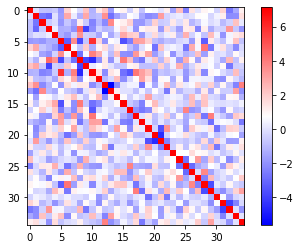

sample 1   label, 0.0


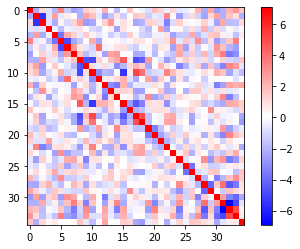

sample 2   label, 0.0


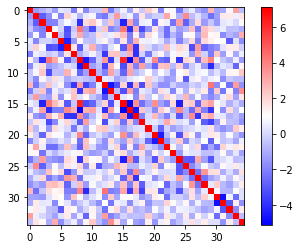

sample 3   label, 0.0


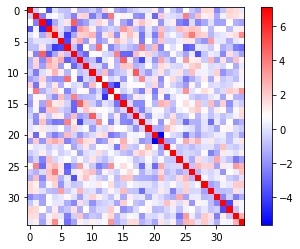

sample 4   label, 0.0


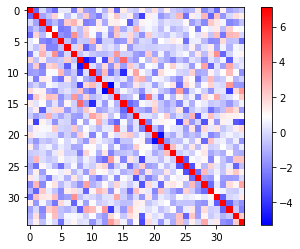

sample 5   label, 0.0


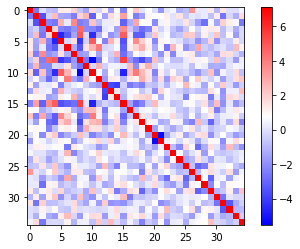

sample 6   label, 0.0


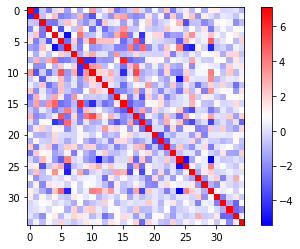

sample 7   label, 0.0


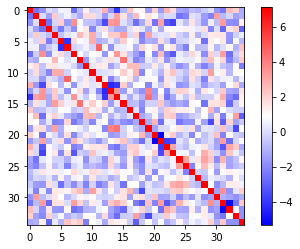

sample 8   label, 0.0


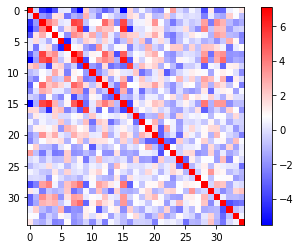

sample 9   label, 0.0


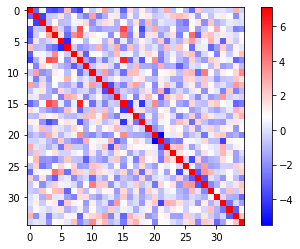

In [11]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Neural Ordinary Differential Equations (GNODE)

[short description here]

##### 2.2.1 Declare Parameters for GNODE

In [27]:
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEcheckpoint = {'parameters': GDEparameters}

##### 2.2.2 Train GNODE

In [28]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GDEmodel, GDEcheckpoint = GDEutil.train_GDE(A, X_train, X_test, GDEcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/21 [00:00<?, ?it/s]

device set to cpu


  5%|▍         | 1/21 [00:02<00:45,  2.26s/it]

 10%|▉         | 2/21 [00:04<00:42,  2.23s/it]

 14%|█▍        | 3/21 [00:06<00:40,  2.23s/it]

 19%|█▉        | 4/21 [00:08<00:37,  2.21s/it]

 24%|██▍       | 5/21 [00:11<00:35,  2.22s/it]

 29%|██▊       | 6/21 [00:13<00:33,  2.22s/it]

 33%|███▎      | 7/21 [00:15<00:31,  2.22s/it]

 38%|███▊      | 8/21 [00:17<00:29,  2.24s/it]

 43%|████▎     | 9/21 [00:19<00:26,  2.21s/it]

 48%|████▊     | 10/21 [00:22<00:24,  2.19s/it]

 52%|█████▏    | 11/21 [00:24<00:21,  2.17s/it]

 57%|█████▋    | 12/21 [00:26<00:19,  2.18s/it]

 62%|██████▏   | 13/21 [00:28<00:17,  2.16s/it]

 67%|██████▋   | 14/21 [00:30<00:15,  2.16s/it]

 71%|███████▏  | 15/21 [00:32<00:12,  2.16s/it]

 76%|███████▌  | 16/21 [00:35<00:10,  2.18s/it]

 81%|████████  | 17/21 [00:37<00:08,  2.17s/it]

 86%|████████▌ | 18/21 [00:39<00:06,  2.16s/it]

 90%|█████████ | 19/21 [00:41<00:04,  2.14s/it]

100%|██████████| 21/21 [00:43<00:00,  2.08s/it]

Epoch: 1   Batch: 21 of size 128   Train loss: 183.19869995117188   Valid loss: 185.51708984375188


In [16]:
#optional: saving the model
GDEutil.save_ckp(GDEcheckpoint, "models/GDE253_1.pt")

model saved


##### 2.2.3 Visualize some simularity matrices generated by GNODE (a visual evaluation and sanity check)

In [14]:
GDEmodel.eval()
test_pred = GDEmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


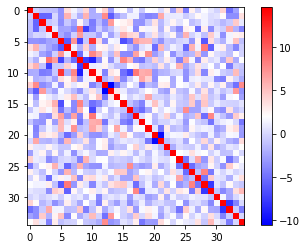

sample 1   label, 0.0


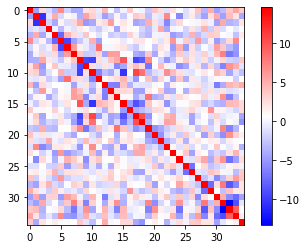

sample 2   label, 0.0


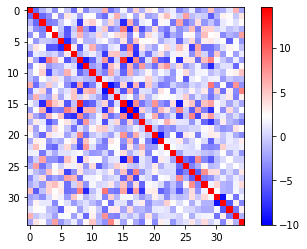

sample 3   label, 0.0


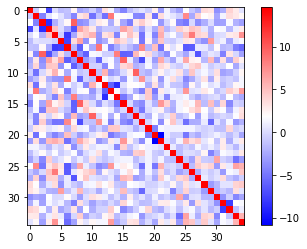

sample 4   label, 0.0


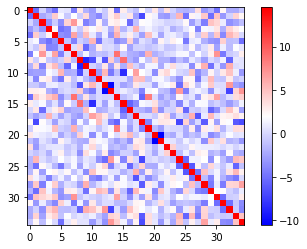

sample 5   label, 0.0


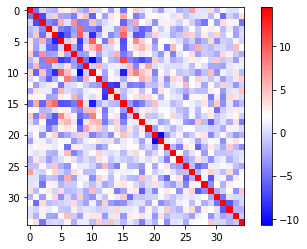

sample 6   label, 0.0


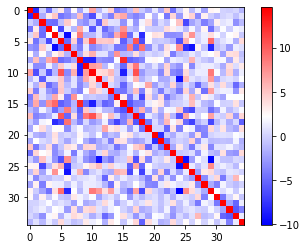

sample 7   label, 0.0


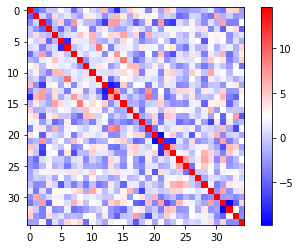

sample 8   label, 0.0


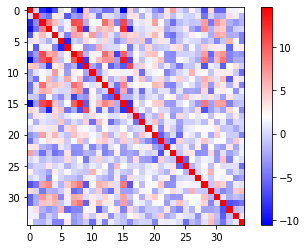

sample 9   label, 0.0


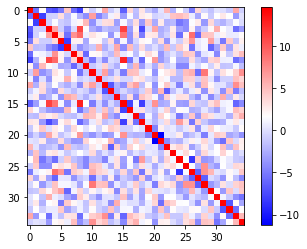

In [15]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 3.1 Supervised Multi-Layer Perceptron (MLP)

[short description here]

##### 3.1.1 Get simularity matrix from GCN and GNODE models

In [29]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

In [30]:
#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [31]:
#Get simularity matrix from GNODE
GDEmodel.eval()
sim_all["GDE_train"] = GDEmodel(torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_all["GDE_test"] = GDEmodel(torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

##### 3.1.2 Visualize the averaged ictal and non-ictal states for the two models

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


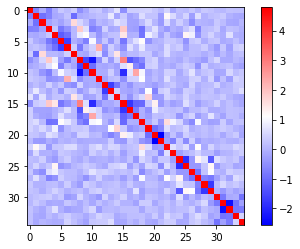

Average Non-Ictal


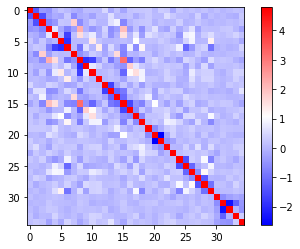

In [32]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


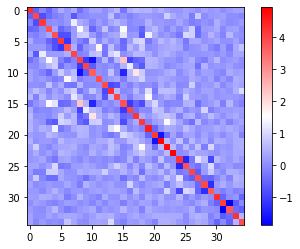

Average Non-Ictal


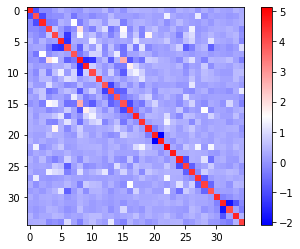

In [33]:
print("Average Ictal and Non-Ictal Simularity Matrix for GDE")
visualize_avg_sim_matrix(dm, sim_all["GDE_train"], sim_all["GDE_test"])

##### 3.1.3 MLP for GCN  

###### Training

In [34]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=630, out_features=630, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=630, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 630]               0
            Linear-2                  [-1, 630]         397,530
              ReLU-3                  [-1, 630]               0
           Dropout-4                  [-1, 630]               0
            Linear-5                    [-1, 1]             631
           Sigmoid-6                    [-1, 1]               0
Total params: 398,161
Trainable params: 398,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.

In [18]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGCN, "models/MLPGCN253_2.pt")

model saved


###### Result

In [35]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda', threshold = t)

device set to cuda
threshold: 0.05  validation loss: 0.2187 F1 accuracy 0.676 Precision accuracy 0.636 Recall accuracy 0.722 AUC accuracy: 0.915
device set to cuda
threshold: 0.1  validation loss: 0.2187 F1 accuracy 0.714 Precision accuracy 0.745 Recall accuracy 0.685 AUC accuracy: 0.915
device set to cuda
threshold: 0.15  validation loss: 0.2187 F1 accuracy 0.724 Precision accuracy 0.799 Recall accuracy 0.661 AUC accuracy: 0.915
device set to cuda
threshold: 0.2  validation loss: 0.2187 F1 accuracy 0.713 Precision accuracy 0.819 Recall accuracy 0.631 AUC accuracy: 0.915
device set to cuda
threshold: 0.25  validation loss: 0.2187 F1 accuracy 0.71 Precision accuracy 0.849 Recall accuracy 0.61 AUC accuracy: 0.915
device set to cuda
threshold: 0.3  validation loss: 0.2187 F1 accuracy 0.704 Precision accuracy 0.874 Recall accuracy 0.59 AUC accuracy: 0.915
device set to cuda
threshold: 0.35  validation loss: 0.2187 F1 accuracy 0.685 Precision accuracy 0.882 Recall accuracy 0.559 AUC accurac

##### 3.1.2 MLP for GDE

###### Training

In [36]:
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 64], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGDE, _,_, MLPcheckpointGDE = MLP.train_MLP(dm, sim_all["GDE_train"], sim_all["GDE_test"], MLPparametersGDE, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=630, out_features=9, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=9, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 630]               0
            Linear-2                    [-1, 9]           5,679
              ReLU-3                    [-1, 9]               0
           Dropout-4                    [-1, 9]               0
            Linear-5                    [-1, 1]              10
           Sigmoid-6                    [-1, 1]               0
Total params: 5,689
Trainable params: 5,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estim

In [ ]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGDE, "models/MLPGDE253_1.pt")

###### Result

In [37]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGDE, sim_all["GDE_test"], dm, device_name = 'cuda', threshold = t)

device set to cuda
threshold: 0.05  validation loss: 0.1768 F1 accuracy 0.537 Precision accuracy 0.39 Recall accuracy 0.864 AUC accuracy: 0.923
device set to cuda
threshold: 0.1  validation loss: 0.1768 F1 accuracy 0.632 Precision accuracy 0.507 Recall accuracy 0.837 AUC accuracy: 0.923
device set to cuda
threshold: 0.15  validation loss: 0.1768 F1 accuracy 0.694 Precision accuracy 0.609 Recall accuracy 0.807 AUC accuracy: 0.923
device set to cuda
threshold: 0.2  validation loss: 0.1768 F1 accuracy 0.724 Precision accuracy 0.678 Recall accuracy 0.776 AUC accuracy: 0.923
device set to cuda
threshold: 0.25  validation loss: 0.1768 F1 accuracy 0.745 Precision accuracy 0.734 Recall accuracy 0.756 AUC accuracy: 0.923
device set to cuda
threshold: 0.3  validation loss: 0.1768 F1 accuracy 0.754 Precision accuracy 0.777 Recall accuracy 0.732 AUC accuracy: 0.923
device set to cuda
threshold: 0.35  validation loss: 0.1768 F1 accuracy 0.762 Precision accuracy 0.82 Recall accuracy 0.712 AUC accura

Questions for Nafiseh:
1. Shuffling the dataset greatly reduces overfitting and improves the accuracy. Can we shuffle the dataset? Is removing the overlapping signals a valid way to shuffle the dataset?
2. Even without shuffling the dataset, removing overlapping signals still greatly improves the validation accuracy. Should we remove the overlapping signal?
3. The built-in AUC metric in Scikit-learn yields a lot higher accuracy than the maximum F-score obatined. Is it normal? What is your AUC accuracy implementation?